In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer,Conv2D,MaxPool2D,Dropout,Activation,Flatten,Dense,AvgPool2D,concatenate,Softmax,Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np

import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

In [3]:
# 定义Inception 模块类
class Inception(Layer,):
    def __init__(self, cov1_1,cov_reduce3_3,cov3_3,cov_reduce5_5,cov5_5,pool_proj, **kwargs):#inception类的构造函数
        super(Inception, self).__init__(**kwargs)#调用了父类的构造函数，确保正确地初始化 Inception 类的实例。
        #创建了一个包含一个卷积层的分支，该卷积层具有 cov1_1 个过滤器（filters），卷积核大小为 1x1，并使用 ReLU 激活函数。
        self.branch1 = Conv2D(filters=cov1_1,kernel_size=1,activation='relu') 
        
        #创建了第二个分支，这个分支是一个由两个卷积层组成的序列，第一层具有 cov_reduce3_3 个过滤器，卷积核大小为 1x1，使用 ReLU 激活函数。
        #第二层具有 cov3_3 个过滤器，卷积核大小为 3x3，使用 ReLU 激活函数，并采用“same”填充，以保持输入和输出的空间尺寸相同。
        self.branch2 = tf.keras.Sequential([
            Conv2D(filters=cov_reduce3_3,kernel_size=1,activation='relu'),
            Conv2D(filters=cov3_3,kernel_size=3,padding='same',activation='relu')
        ])
        
        #创建了第三个分支，类似于第二个分支，但是卷积核大小为 5x5。
        self.branch3 = tf.keras.Sequential([
            Conv2D(filters=cov_reduce5_5,kernel_size=1,activation='relu'),
            Conv2D(filters=cov5_5,kernel_size=5,padding='same',activation='relu')
        ])
        
        #创建了第四个分支，包含一个最大池化层（池化窗口大小为 3x3，步幅为 1，使用“same”填充），
        #后接一个具有 pool_proj 个过滤器的 1x1 卷积层，并使用 ReLU 激活函数。
        self.branch4 = tf.keras.Sequential([
            MaxPool2D(pool_size=3,strides=1,padding='same'),
            Conv2D(filters=pool_proj,kernel_size=1,activation='relu')
        ])
        
    def call(self,inputs):
        # 分别通过四个分支处理输入数据
        branch1 = self.branch1(inputs)
        branch2 = self.branch2(inputs)
        branch3 = self.branch3(inputs)
        branch4 = self.branch4(inputs)
         # 将四个分支的输出连接在一起
        outputs = concatenate([branch1,branch2,branch3,branch4])
        return outputs
        
# 定义辅助分类器
class AuxiliaryClassifier(Layer,):
    def __init__(self, **kwargs):
        super(AuxiliaryClassifier, self).__init__(**kwargs)#调用父类（Layer类）的初始化方法
        self.avgpool = AvgPool2D(pool_size=5,strides=3)#创建一个平均池化层，池化窗口大小为5x5，步幅为3。
        self.conv = Conv2D(filters=128,kernel_size=1,activation='relu')#创建一个卷积层，包含128个滤波器，卷积核大小为1x1，激活函数为ReLU。
        self.flatten = Flatten()#创建一个展平层，用于将卷积层的输出展平成一维向量。
        self.fc1 = Dense(units=1024,activation="relu")#创建一个全连接层，包含1024个神经元，激活函数为ReLU。
        self.dropout = Dropout(rate=0.7)#创建一个Dropout层，用于随机丢弃输入单元，防止过拟合，丢弃率为70%。
        self.fc2 = Dense(units=1000,activation="softmax")#创建一个全连接层，包含1000个神经元，激活函数为Softmax，用于输出分类概率。
        
    def call(self,inputs):
        x = self.avgpool(inputs)#对输入数据进行平均池化操作。
        x = self.conv(x)#对池化后的数据进行卷积操作。
        x = self.flatten(x)#将卷积层输出的多维数据展平成一维向量。
        x = self.fc1(x)#对展平后的数据进行全连接操作。
        x = self.dropout(x)#对全连接层的输出进行Dropout操作，以减少过拟合。
        outputs = self.fc2(x)#最后一层全连接层，输出最终的分类概率。
        return outputs     

def GoogLeNet(model_name='GoogLeNet',im_height=224,im_width=224,class_num=1000):
#     inputs = tf.keras.Input(shape=(im_height,im_width,3),name='Inputs')
    inputs = Input(shape=(im_height,im_width,3),name='Inputs')
    
    # input [224,224,3]  -->  [112,112,64]
    x = Conv2D(filters=64,kernel_size=7,strides=2,padding='same',activation='relu',name='convolution-1')(inputs)
    # [112,112,64]  -->  [56,56,64]
    x = MaxPool2D(pool_size=3,strides=2,padding='same',name='max-pool-1')(x)
    # [56,56,64]  -->  [56,56,192]
    x = Conv2D(filters=192,kernel_size=3,strides=1,padding='same',activation='relu',name='convolution-2')(x)
    # [56,56,192]  -->  [28,28,192]
    x = MaxPool2D(pool_size=3,strides=2,padding='same',name='max-pool-2')(x)
    # [28,28,192] --> [28, 28, 256]
    x = Inception(64,96,128,16,32,32,name='inception-3a')(x)
    # [28, 28, 256] --> [28, 28, 480]
    x = Inception(128,128,192,32,96,64,name='inception-3b')(x)
    # [28, 28, 480] --> [14, 14, 480]
    x = MaxPool2D(pool_size=3,strides=2,padding='same',name='max-pool-3')(x)
    # [14, 14, 480] --> [14, 14, 512]
    x = Inception(192,96,208,16,48,64,name='inception-4a')(x)
    # [14, 14, 512] --> [1000]
    outputs1 = AuxiliaryClassifier(name='AuxiliaryClassifier-1')(x)
    # [14, 14, 512] --> [14, 14, 512]
    x = Inception(160,112,224,24,64,64,name='inception-4b')(x)
    # [14, 14, 512] --> [14, 14, 512]
    x = Inception(128,128,256,24,64,64,name='inception-4c')(x)
    # [14, 14, 512] --> [14, 14, 528]
    x = Inception(112,144,288,32,64,64,name='inception-4d')(x)
    # [14, 14, 528] --> [1000,]
    outputs2 = AuxiliaryClassifier(name='AuxiliaryClassifier-2')(x)
    # [14, 14, 528] --> [14, 14, 832]
    x = Inception(256,160,320,32,128,128,name='inception-4e')(x)
    # [14, 14, 832] --> [7, 7, 832]
    x = MaxPool2D(pool_size=3,strides=2,padding='same',name='max-pool-4')(x)
    # [7, 7, 832] --> [7, 7, 832]
    x = Inception(256,160,320,32,128,128,name='inception-5a')(x)
    # [7, 7, 832] --> [7, 7, 1024]
    x = Inception(384,192,384,48,128,128,name='inception-5b')(x)
    # [7, 7, 1024] --> [1, 1, 1024]
    x = AvgPool2D(pool_size=7,strides=1,name='avg-pool')(x)
    # [1, 1, 1024] --> [1024,]
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.4,name='dropout')(x)
    x = Dense(units=1000,name='linear')(x)
    outputs = Softmax(name='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs,outputs=[outputs1,outputs2,outputs],name='GoogLeNet')
    return model
model = GoogLeNet()
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Inputs (InputLayer)         [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convolution-1 (Conv2D)      (None, 112, 112, 64)         9472      ['Inputs[0][0]']              
                                                                                                  
 max-pool-1 (MaxPooling2D)   (None, 56, 56, 64)           0         ['convolution-1[0][0]']       
                                                                                                  
 convolution-2 (Conv2D)      (None, 56, 56, 192)          110784    ['max-pool-1[0][0]']          
                                                                                          

In [5]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [6]:
#调整输入数据的维度
train_images_rgb = np.repeat(train_images, 3, axis=3)  # 复制灰度通道，创建RGB图片
test_images_rgb = np.repeat(test_images, 3, axis=3)

train_images_resized = tf.image.resize(train_images_rgb, [224, 224])
test_images_resized = tf.image.resize(test_images_rgb, [224, 224])

In [7]:
model.fit(train_images_resized, train_labels, epochs=5, validation_data=(test_images_resized, test_labels))

C:\Users\HUAWEI\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
1875/1875 [==============================] - 23528s 13s/step - loss: 2.0521 - AuxiliaryClassifier-1_loss: 0.6632 - AuxiliaryClassifier-2_loss: 0.6925 - softmax_loss: 0.6963 - AuxiliaryClassifier-1_accuracy: 0.7610 - AuxiliaryClassifier-2_accuracy: 0.7570 - softmax_accuracy: 0.7520 - val_loss: 1.2270 - val_AuxiliaryClassifier-1_loss: 0.4014 - val_AuxiliaryClassifier-2_loss: 0.3894 - val_softmax_loss: 0.4363 - val_AuxiliaryClassifier-1_accuracy: 0.8519 - val_AuxiliaryClassifier-2_accuracy: 0.8598 - val_softmax_accuracy: 0.8450
Epoch 2/5
1875/1875 [==============================] - 6507s 3s/step - loss: 1.0628 - AuxiliaryClassifier-1_loss: 0.3585 - AuxiliaryClassifier-2_loss: 0.3561 - softmax_loss: 0.3483 - AuxiliaryClassifier-1_accuracy: 0.8705 - AuxiliaryClassifier-2_accuracy: 0.8705 - softmax_accuracy: 0.8724 - val_loss: 0.9241 - val_AuxiliaryClassifier-1_loss: 0.3035 - val_AuxiliaryClassifier-2_loss: 0.3120 - val_softmax_loss: 0.3086 - val_AuxiliaryClassifier-1_accuracy: 0.8

In [9]:


result = model.evaluate(test_images_resized, test_labels)
test_loss = result[0]
test_acc = result[1]
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 229s 733ms/step - loss: 0.7130 - AuxiliaryClassifier-1_loss: 0.2389 - AuxiliaryClassifier-2_loss: 0.2355 - softmax_loss: 0.2385 - AuxiliaryClassifier-1_accuracy: 0.9120 - AuxiliaryClassifier-2_accuracy: 0.9150 - softmax_accuracy: 0.9127
Test accuracy: 0.23892414569854736


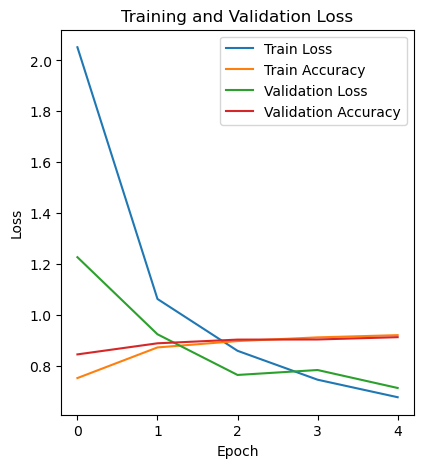

In [1]:
import matplotlib.pyplot as plt

# 提取训练和验证集上的loss和accuracy
train_loss = [2.0521, 1.0628, 0.8591, 0.7455, 0.6767]
train_accuracy = [0.7520, 0.8724, 0.8974, 0.9119, 0.9206]

val_loss = [1.2270, 0.9241, 0.7642, 0.7836, 0.7130]
val_accuracy = [0.8450, 0.8886, 0.9031, 0.9036, 0.9127]

# 绘制loss曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_loss, label='Validation Loss')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()